Exploring torch for the sfNorm model

Last access:  20.12.02  
Last update:  20.12.02  

In [1735]:
import torch
import torch.nn as nn
from torch.utils import data as torchdata

import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
%matplotlib inline

import seaborn as sns

import sys
sys.path.insert(0, '../')
import helper_fcns as hf
import helper_fcns_sfBB as hfsf
import model_responses_pytorch as mrpt

import pdb


In [1736]:
for i in range(2):
    # must run twice for changes to take effect?

    from matplotlib import rcParams, cm
    rcParams['font.family'] = 'sans-serif'
    # rcParams['font.sans-serif'] = ['Helvetica']
    rcParams['font.style'] = 'oblique'
    rcParams['font.size'] = 30;
    rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
    rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues
    rcParams['lines.linewidth'] = 3;
    rcParams['lines.markeredgewidth'] = 0; # remove edge??                                                                                                                               
    rcParams['axes.linewidth'] = 3;
    rcParams['lines.markersize'] = 12; # 8 is the default                                                                                                                                
    rcParams['font.style'] = 'oblique';

    rcParams['xtick.major.size'] = 25
    rcParams['xtick.minor.size'] = 12
    rcParams['ytick.major.size'] = 25
    rcParams['ytick.minor.size'] = 0; # i.e. don't have minor ticks on y...                                                                                                              

    rcParams['xtick.major.width'] = 2
    rcParams['xtick.minor.width'] = 2
    rcParams['ytick.major.width'] = 2
    rcParams['ytick.minor.width'] = 0

In [1737]:
import autoreload as ar
ar.reload(mrpt);

In [1090]:
### Helper
def _cast_as_tensor(x, device_in="cpu"):
    # needs to be float32 to work with the Hessian calculations
    return torch.tensor(x, dtype=torch.float32, device=device_in)

def _cast_as_param(x, device_in="cpu", requires_grad=True):
    # from Billy
    return torch.nn.Parameter(_cast_as_tensor(x, device_in=device_in), requires_grad=requires_grad)


In [1965]:
import autoreload as ar
ar.reload(mrpt);
ar.reload(hf);

In [1922]:
trialInf = coreExp['trial']

In [1969]:
maskOns = [0,1,1,1,0,1];
baseOns = [1,0,0,1,1,0];
whichCons = [-1,4,1,5,3,0];
whichSfs = [3,0,4,1,3,2];

# holdoutTr is test set                                                                                                                                                                                                                                                       
holdoutTr = np.hstack([hf_sf.get_valid_trials(coreExp, maskOn=m, baseOn=x, whichCon=y, whichSf=z) for m,x,y,z in zip(maskOns, baseOns, whichCons, whichSfs)])
allNonBlank = np.where(np.logical_or(trialInf['maskOn'], trialInf['baseOn']))[0]
# keepTr is train set                                                                                                                                                                                                                                                         
keepTr = np.setdiff1d(allNonBlank, holdoutTr)


In [1970]:
excType = 2
lossType = 1
normType = 2
lgnFrontEnd = 0
wow = mrpt.setModel(12, 'V1_BB/', excType=excType, lossType=lossType, fitType=normType, lgnFrontEnd=lgnFrontEnd, initFromCurr=0, respMeasure=0, newMethod=1, vecCorrected=1, whichTrials=keepTr);


FitList: fitList_pyt_201107_vecF1_CV_wght_sqrt.npy
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1_BB/structures/...


../model_responses_pytorch.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)



****** STEP 0 [dc] [prev loss: 0.00] *********

****** STEP 100 [dc] [prev loss: 132.63] *********

****** STEP 200 [dc] [prev loss: 20.28] *********

****** STEP 300 [dc] [prev loss: 18.94] *********

****** STEP 400 [dc] [prev loss: 18.32] *********

****** STEP 500 [dc] [prev loss: 17.55] *********

****** STEP 600 [dc] [prev loss: 16.31] *********

****** STEP 700 [dc] [prev loss: 15.64] *********

****** STEP 800 [dc] [prev loss: 15.22] *********

****** STEP 900 [dc] [prev loss: 14.94] *********

****** STEP 1000 [dc] [prev loss: 14.73] *********

****** STEP 1100 [dc] [prev loss: 14.56] *********

****** STEP 1200 [dc] [prev loss: 14.41] *********

****** STEP 1300 [dc] [prev loss: 14.28] *********

****** STEP 1400 [dc] [prev loss: 14.17] *********
...finished. New NLL (10.33) vs. previous NLL (10.56)
we will be overwriting dc (if updating)


In [1944]:
mns_mod_train, _ = organize_valid_conditions(coreExp, resps=mr_train, respMeasure=rM, vecCorrected=0, val_trials=keepTr)


In [1967]:
fL = hf.np_smart_load('/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1_BB/structures/fitList_pyt_201107_vecF1_CV_wght_sqrt.npy')
prms = fL[11]['dc']['params'];
modCurr = mrpt.sfNormMod(prms, expInd=-1, excType=2, normType=2, lossType=1, lgnFrontEnd=0, newMethod=1)

rM = 0;

# Gather train trInf, data
trInf_train, data_train = mrpt.process_data(coreExp, respMeasure=rM, whichTrials=keepTr)
# Then for test data
trInf_test, data_test = mrpt.process_data(coreExp, respMeasure=rM, whichTrials=holdoutTr)

# Run the model on the two sets of data
mr_train = modCurr.forward(trInf_train, respMeasure=rM).detach().numpy()
mr_test = modCurr.forward(trInf_test, respMeasure=rM).detach().numpy()

### 
# DATA - do vec corrected
# -- first train
mns_dat_train, _ = organize_valid_conditions(coreExp, resps=None, respMeasure=rM, vecCorrected=1, val_trials=keepTr)
mns_dat_train_flat = np.hstack([x.flatten() for x in mns_dat_train])
# -- then test
mns_dat_test, _ = organize_valid_conditions(coreExp, resps=None, respMeasure=rM, vecCorrected=1, val_trials=holdoutTr)
mns_dat_test_flat = np.hstack([x.flatten() for x in mns_dat_test])

# MODEL - NOT vec corrected
# -- first train
mns_mod_train, _ = organize_valid_conditions(coreExp, resps=mr_train, respMeasure=rM, vecCorrected=0, val_trials=keepTr)
mns_mod_train_flat = np.hstack([x.flatten() for x in mns_mod_train])
# -- then test
mns_mod_test, _ = organize_valid_conditions(coreExp, resps=mr_test, respMeasure=rM, vecCorrected=0, val_trials=holdoutTr)
mns_mod_test_flat = np.hstack([x.flatten() for x in mns_mod_test])

if rM == 1:
    mns_dat_base = np.hstack([x.flatten() for x in [mns_dat[0], mns_dat[1]]])
    mns_dat_mask = np.hstack([x.flatten() for x in [mns_dat[2], mns_dat[3]]])
    mns_mod_base = np.hstack([x.flatten() for x in [mns_mod[0], mns_mod[1]]])
    mns_mod_mask = np.hstack([x.flatten() for x in [mns_mod[2], mns_mod[3]]])

    
# curr_corr_tr = np.corrcoef(respFixed[:,maskInd], final_fit[:,maskInd])
# curr_corr_cond = np.corrcoef(mns_dat_mask, mns_mod_mask);
# curr_vE_cond = hf.var_explained(mns_dat_mask, mns_mod_mask, None);


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages

Text(0, 0.5, 'Model')

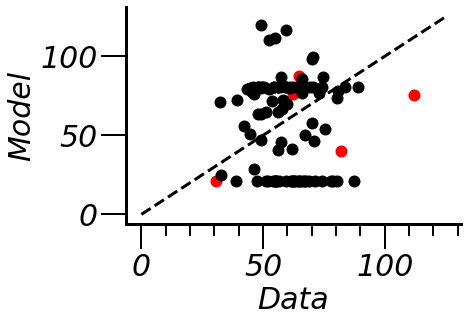

In [1968]:
plt.plot(mns_dat_test_flat, mns_mod_test_flat, 'ro');
plt.plot(mns_dat_train_flat, mns_mod_train_flat, 'ko');
plt.plot([0, 125], [0, 125], 'k--')
plt.xlabel('Data')
plt.ylabel('Model')

In [1960]:
curr_corr_train = np.corrcoef(hf.nan_rm(mns_dat_train_flat), hf.nan_rm(mns_mod_train_flat))

In [1962]:
curr_corr_test = np.corrcoef(hf.nan_rm(mns_dat_test_flat), hf.nan_rm(mns_mod_test_flat))

In [1963]:
curr_corr_test

array([[1.        , 0.45237723],
       [0.45237723, 1.        ]])

In [1952]:
mns_mod_test_flat

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       76.06594086,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, 87.42512512,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan, 75.4134903 ,         nan,         nan,         nan,
               nan,         nan, 21.22468185,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan, 21.22468185,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [1936]:
len(mr_train)

990

In [1832]:
tt, rr = mrpt.process_data(coreExp, respMeasure=0)
ttCV, rrCV = mrpt.process_data(coreExp, respMeasure=0, whichTrials=keepTr)

In [ ]:
mrpt.setModel(12, 'V1_BB', 2, 1, 2, 0, initFromCurr=0, respMeasure=0, newMethod=1, vecCorrected=1);

In [1878]:
oy = np.intersect1d(tt['num'], keepTr)
vey = [np.where(tt['num'] == x)[0][0] for x in keepTr]

In [1637]:
# Set-up the model, data, parameter, etc
cellNum = 12;
loc_str = ''
loc = '../V1_BB/structures/'

if 'BB' in loc:

    dl = hf.np_smart_load('%sdataList.npy' % loc) # for V1_BB/
    cell = hf.np_smart_load('%s%s_sfBB.npy' % (loc, dl['unitName'][cellNum-1]));
    coreExp = cell['sfBB_core'];
    trialInf = coreExp['trial'];
    expInd = -1; # expInd doesn't apply here...

else:
    
    dl = hf.np_smart_load('%sdataList_glx_200507.npy' % loc) # for V1/
    cell = hf.np_smart_load('%s%s_sfm.npy' % (loc, dl['unitName'][cellNum-1]));
    trialInf = cell['sfm']['exp']['trial'];
    expInd = hf.get_exp_ind(loc, dl['unitName'][cellNum-1])[0];

new_params = 0; # i.e. automatically get init params or try to load?
    
excType=2
normType=2
lossType=1
lgnFrontEnd=0
newMethod = 1
respMeasure = 1; # DC [0]...or F1 [1]

if excType == 1:
    fL_name = 'fitList%s_pyt_200417' % (loc_str);
elif excType == 2:
    fL_name = 'fitList%s_pyt_201107_vecF1' % (loc_str);
    
if lgnFrontEnd == 1:
    fL_name = '%s_LGN' % fL_name # implicit "a" at the end of LGN... 
elif lgnFrontEnd == 2:
    fL_name = '%s_LGNb' % fL_name

if 'BB' in loc and new_params:
    initFromCurr = 0
    # --- first, estimate prefSf, normConst if possible (TODO)                                                                                                                         
    prefSfEst = 1;
    normConst = -2;
    # --- then, set up each parameter                                                                                                                                                  
    pref_sf = float(prefSfEst) if initFromCurr==0 else curr_params[0];
    if excType == 1:
        dOrdSp = np.random.uniform(1, 3) if initFromCurr==0 else curr_params[1];
    elif excType == 2:
#         sigLow = np.random.uniform(0.1, 0.3) if initFromCurr==0 else curr_params[1];
        sigLow = np.random.uniform(0.75, 1.25) if initFromCurr==0 else curr_params[1];
        sigHigh = sigLow*np.random.uniform(1, 2) if initFromCurr==0 else curr_params[-1-np.sign(lgnFrontEnd)];                                                                                                        
    normConst = normConst if initFromCurr==0 else curr_params[2];
    respExp = np.random.uniform(1.5, 2.5) if initFromCurr==0 else curr_params[3];
    
    # easier to start with a small scalar and work up, rather than work down                                                                                                           
#     respScalar = np.random.uniform(10, 20) if initFromCurr==0 else curr_params[4];
#     respScalar = np.random.uniform(500, 750) if initFromCurr==0 else curr_params[4];
    respScalar = np.random.uniform(0.01, 0.05) if initFromCurr==0 else curr_params[4];

    noiseEarly = 1e-3 if initFromCurr==0 else curr_params[5];
#     noiseEarly = np.random.uniform(0.001, 0.01) if initFromCurr==0 else curr_params[5];
    noiseLate = 1e-1 if initFromCurr==0 else curr_params[6];
#     noiseLate = np.random.uniform(-1e1, 1e-2) if initFromCurr==0 else curr_params[6];
#     noiseLate = np.random.uniform(0.1, 1) if initFromCurr==0 else curr_params[6];
    varGain = np.random.uniform(0.1, 1) if initFromCurr==0 else curr_params[7];
    if lgnFrontEnd > 0:
        # Now, the LGN weighting                                                                                                                                                         
        mWeight = np.random.uniform(0.25, 0.75) if initFromCurr==0 else curr_params[-1];
    else:
        mWeight = -99;

    # --- finally, actually create the parameter list                                                                                                                                  
    if normType == 1:
        inhAsym = 0
        if excType == 1:
            param_list = (pref_sf, dOrdSp, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, inhAsym, mWeight);
        elif excType == 2:
            param_list = (pref_sf, sigLow, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, inhAsym, sigHigh, mWeight);
    elif normType == 2:
        normMean = np.log10(prefSfEst)
        normStd = 0.5;
        if excType == 1:
            param_list = (pref_sf, dOrdSp, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, normMean, normStd, mWeight);
        elif excType == 2:
            param_list = (pref_sf, sigLow, normConst, respExp, respScalar, noiseEarly, noiseLate, varGain, normMean, normStd, sigHigh, mWeight);
    if lgnFrontEnd == 0: # then we'll trim off the last constraint, which is mWeight bounds (and the last param, which is mWeight)                                                   
        param_list = param_list[0:-1];   
    
    fitParams = param_list;    
else:
    fitListName = hf.fitList_name(base=fL_name, fitType=normType, lossType=lossType);
    fL = hf.np_smart_load('%s%s' % (loc,fitListName))
    if 'BB' in loc:
        fitParams = [fL[cellNum-1][x]['params'] for x in ['dc', 'f1']];
    else:
        fitParams = fL[cellNum-1]['params']

In [1638]:
ar.reload(mrpt);
ar.reload(hfsf);
ar.reload(hf);

In [1639]:
# modTest = mrpt.sfNormMod(fitParams, expInd, excType=excType, normType=normType, lossType=lossType, lgnFrontEnd=lgnFrontEnd)
if 'BB' in loc and new_params: 
    fp = np.copy(fitParams);
else:
    if respMeasure == 1:
        fp = fitParams[1];
    else:
        fp = fitParams[0] 
    
modTrain = mrpt.sfNormMod(fp, expInd, excType=excType, normType=normType, lossType=lossType, lgnFrontEnd=lgnFrontEnd, newMethod=newMethod)


In [1640]:
trInf, resp = mrpt.process_data(coreExp, expInd=-1, respMeasure=respMeasure)

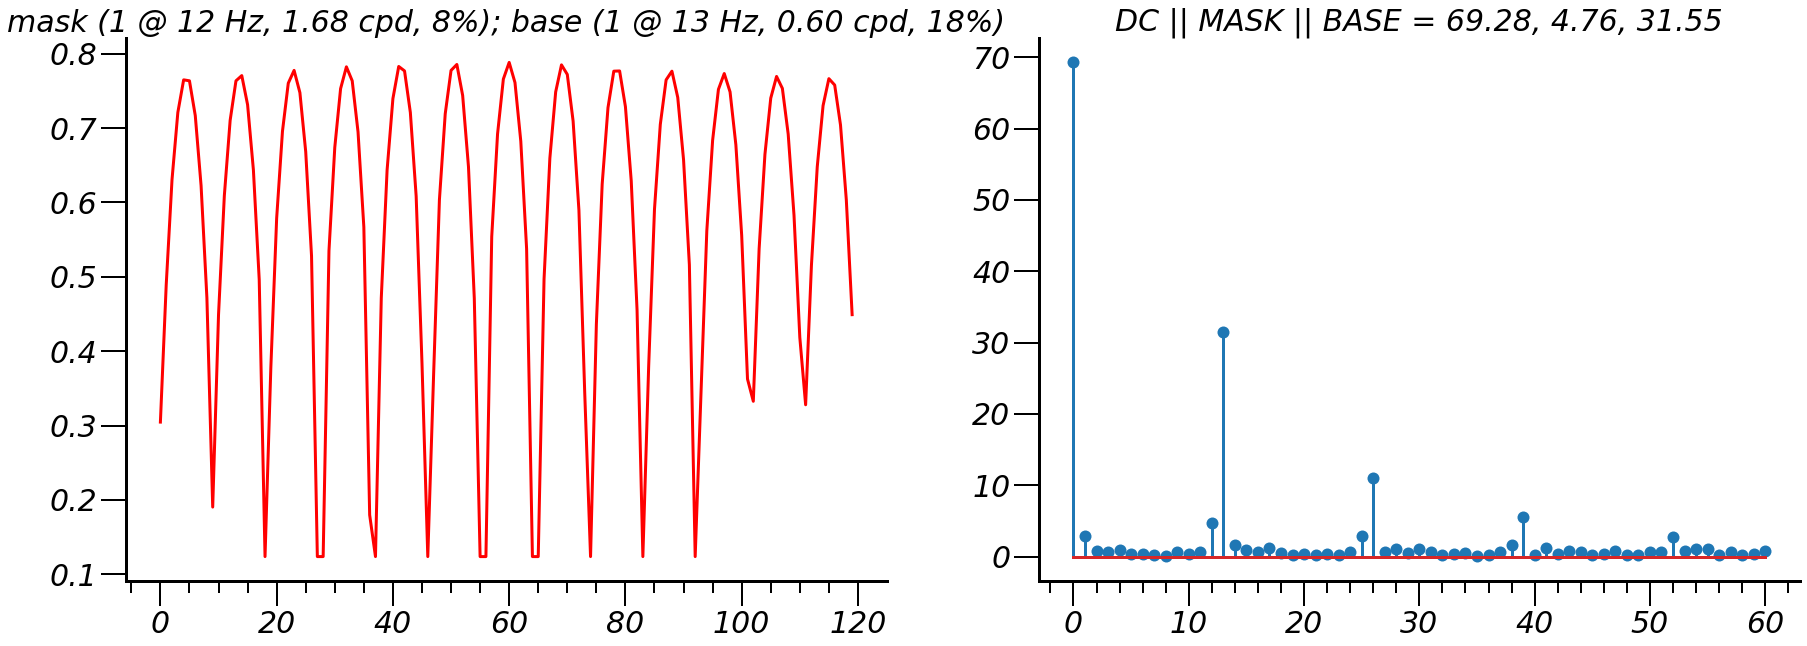

In [1641]:
expInd = -1; # sfBB is -1 expInd code

# What's the trial #, associated stimulus (esp. TF)?
trNum = 7; #7 - BOTH (for cell #7) # 111 - only mask (for cell #7); # 117 - only base (for cell #7)
curr_trials = trInf['num'];
maskInd, baseInd = hf_sf.get_mask_base_inds();
maskO, baseO = trialInf['maskOn'][curr_trials[trNum]], trialInf['baseOn'][curr_trials[trNum]]
baseTf, maskTf = trInf['tf'][trNum, baseInd], trInf['tf'][trNum, maskInd]
baseSf, maskSf = trInf['sf'][trNum, baseInd], trInf['sf'][trNum, maskInd]
baseCon, maskCon = trInf['con'][trNum, baseInd], trInf['con'][trNum, maskInd]

nrow, ncol = 1, 2;

# init_fit, init_psth = model.forward(trInf, respMeasure=respMeasure, returnPsth=1)
init_fit, init_psth = modTrain.forward(trInf, respMeasure=respMeasure, returnPsth=1)

# PSTH
f, ax = plt.subplots(nrow, ncol, figsize=(15*ncol, 10*nrow))
ax[0].set_title('mask (%d @ %d Hz, %.2f cpd, %d%%); base (%d @ %d Hz, %.2f cpd, %d%%)' % (maskO, maskTf, maskSf, np.round(100*maskCon), 
                                                                                  baseO, baseTf, baseSf, np.round(100*baseCon)))

psth = init_psth;
ax[0].plot(psth[trNum, :].detach().numpy(), 'r')

# FFT
stimDur = hf.get_exp_params(expInd).stimDur
nFrames = len(psth)/stimDur;
tfAsInts = np.array([int(maskTf), int(baseTf)]);

# amps, rel_amps, full_fourier, w_phase = mrpt.spike_fft([psth], tfs=[tfAsInts], stimDur=stimDur, binWidth=1.0/nFrames, inclPhase=1)
amps, rel_amps, full_fourier = mrpt.spike_fft([psth], tfs=[tfAsInts], stimDur=stimDur, binWidth=1.0/nFrames)
unwrap = amps[0][trNum, :].detach().numpy();
# unwrap = amps[0][:, trNum].detach().numpy();
ax[1].stem(unwrap)
ax[1].set_title('DC || MASK || BASE = %.2f, %.2f, %.2f' % (unwrap[0], unwrap[tfAsInts[maskInd]], unwrap[tfAsInts[baseInd]]));




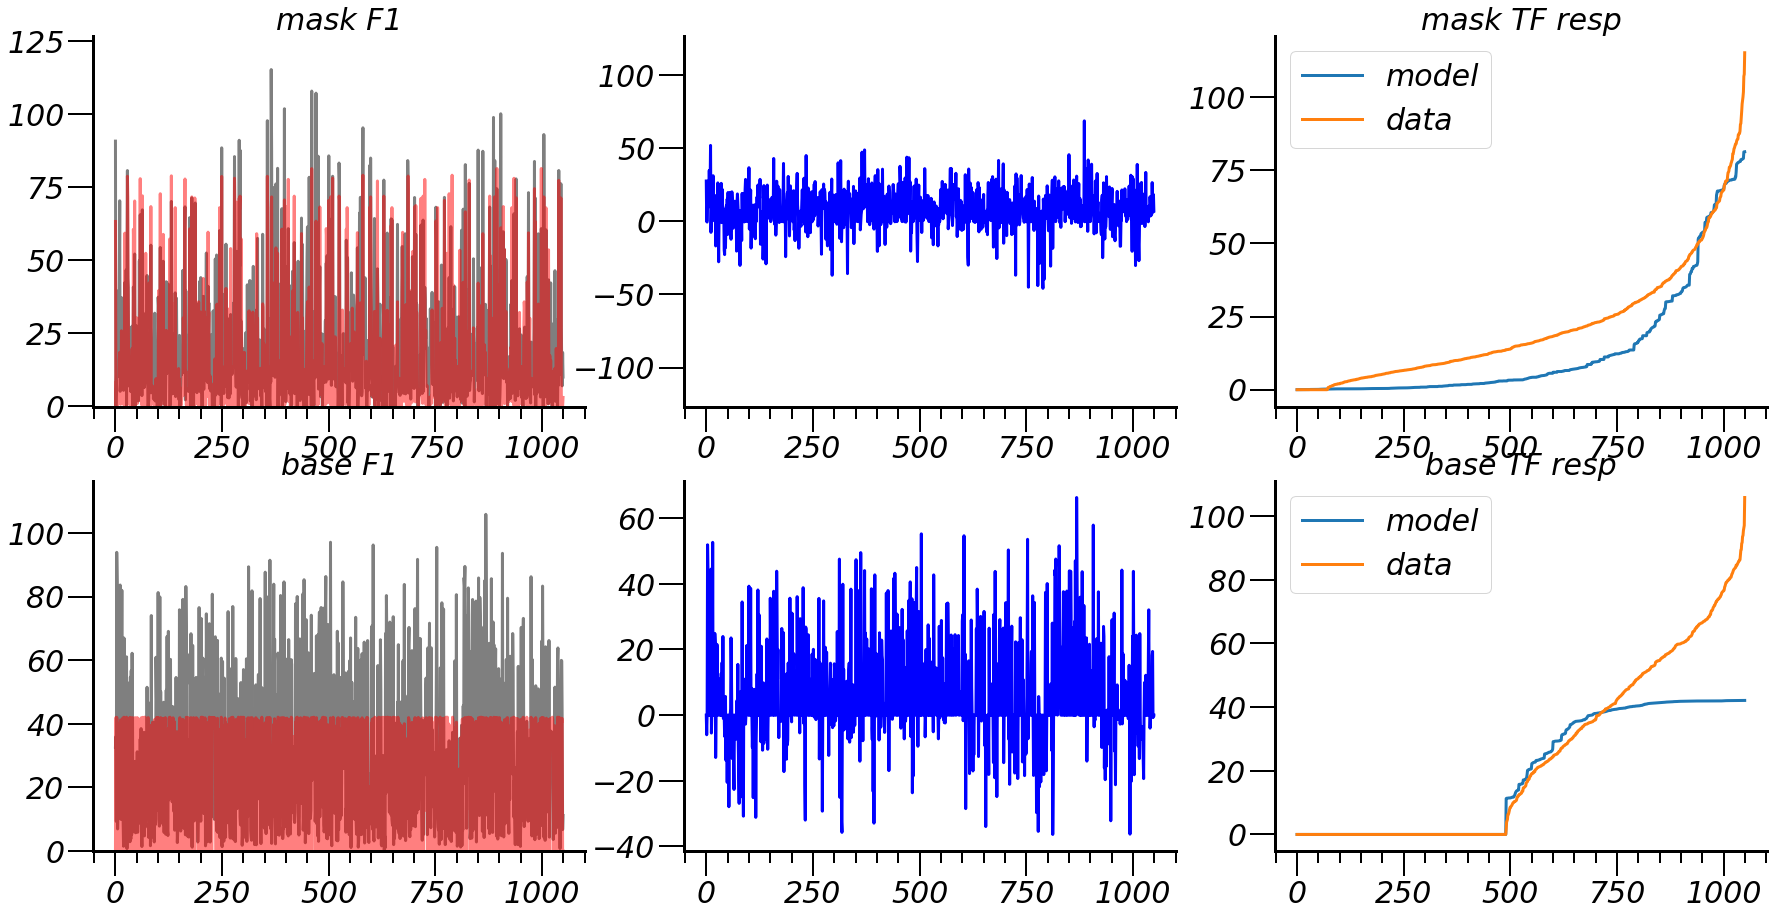

In [1642]:
# let's correct the responses to have a "zero" F1 amplitude when the contrast for that component (mask or base) is 0%
respFixed = resp.copy();
maskInd, baseInd = hf_sf.get_mask_base_inds();
respFixed[trInf['con'][:,maskInd]==0, maskInd] = 0 # force F1 = 0 if con of that stim is 0
respFixed[trInf['con'][:,baseInd]==0, baseInd] = 0 # force F1 = 0 if con of that stim is 0


if respMeasure == 0:
    f, ax = plt.subplots(figsize=(30, 15))
    plt.subplot(1,2,1)

    init_as_np = init_fit[:,].detach().numpy()
    plt.plot(resp, 'k', alpha=0.5)
    # plt.plot(output[:,].detach(), 'k')
    plt.plot(init_as_np, 'r', alpha=0.5)
    max_resp = np.maximum(np.max(resp), np.max(init_as_np));
    plt.ylim([-0.1, 1.1*max_resp]);

    plt.subplot(1,2,2)
    plt.plot(resp - init_as_np, 'b')
    plt.ylim([-1.1*max_resp, 1.1*max_resp]);
    
if respMeasure == 1: # i.e. F1
    f, ax = plt.subplots(figsize=(30,15))

    plt.subplot(2,3,1) # top row will be mask
    init_as_np = init_fit.detach().numpy()
    plt.plot(respFixed[:,0], 'k', alpha=0.5)
    # plt.plot(output[:,].detach(), 'k')
    plt.plot(init_as_np[:,0], 'r', alpha=0.5)
    max_resp = np.maximum(np.max(resp[:,0]), np.max(init_as_np[:,0]));
    plt.ylim([-0.1, 1.1*max_resp]);
    plt.title('mask F1')

    plt.subplot(2,3,2)
    plt.plot(respFixed[:,0] - init_as_np[:,0], 'b')
    plt.ylim([-1.1*max_resp, 1.1*max_resp]);
    
    plt.subplot(2,3,3)
    # data vs model (just mask F1)
    plt.title('mask TF resp')
    plt.plot(sorted(init_fit[:,0]), label='model')
    plt.plot(sorted(respFixed[:,0]), label='data')
    plt.legend();
    
    plt.subplot(2,3,4) # bottom row will be base
    plt.plot(resp[:,1], 'k', alpha=0.5)
    # plt.plot(output[:,].detach(), 'k')
    plt.plot(init_as_np[:,1], 'r', alpha=0.5)
    max_resp = np.maximum(np.max(respFixed[:,1]), np.max(init_as_np[:,1]));
    plt.ylim([-0.1, 1.1*max_resp]);
    plt.title('base F1')

    plt.subplot(2,3,5)
    plt.plot(respFixed[:,1] - init_as_np[:,1], 'b')
    
    plt.subplot(2,3,6)
    # data vs model (just base F1)
    plt.title('base TF resp')
    plt.plot(sorted(init_fit[:,1]), label='model')
    plt.plot(sorted(respFixed[:,1]), label='data')
    plt.legend();


In [1643]:
# test...
init_mask = init_as_np[:,0]
init_base = init_as_np[:,1]
val_trials = trInf['num'];

_, mod, _, modAll = hf_sf.get_mask_resp(coreExp, withBase=0, maskF1=1, f1_base=init_base, f1_mask=init_mask, val_trials=val_trials, returnByTr=1)
_, dat, _, datAll = hf_sf.get_mask_resp(coreExp, withBase=0, maskF1=1, returnByTr=1)

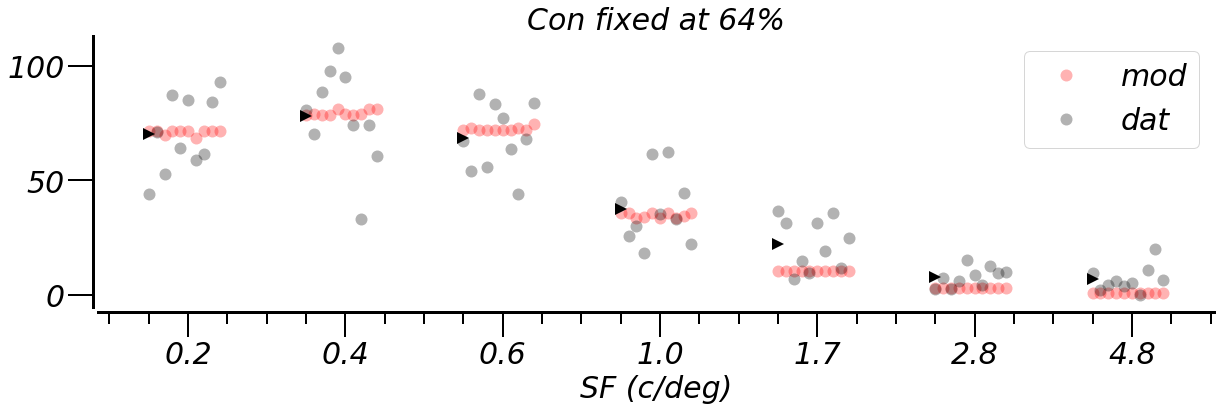

In [1701]:
# plt.plot(sorted(mod[:,:,0].flatten()))
# plt.plot(sorted(dat[:,:,0].flatten()))

# plt.figure(figsize=(20, 5))
# plt.plot(modAll.flatten(), 'o', label='mod', alpha=0.3)
# plt.plot(datAll.flatten(), 'o', label='dat', alpha=0.3)
# plt.legend()

plt.figure(figsize=(20, 5))
ind = -1
fixCon = 1; # con is the 0th dim, SF is the 1st, trial-by-trial response is the 2nd & final
if fixCon:
    plt.plot(modAll[ind,:,:].flatten(), 'ro', label='mod', alpha=0.3)
    plt.plot(datAll[ind,:,:].flatten(), 'ko', label='dat', alpha=0.3)
    # plot mean of data?
    [plt.plot(20*i+0, np.mean(datAll[ind,i,0:10]), 'k>') for i in range(7)]
else:
    plt.plot(modAll[:, ind,:].flatten(), 'ro', label='mod', alpha=0.3)
    plt.plot(datAll[:, ind,:].flatten(), 'ko', label='dat', alpha=0.3)
    # plot mean of data?
    [plt.plot(20*i+0, np.mean(datAll[i,ind,0:10]), 'k>') for i in range(7)]
# relabel xaxes
if fixCon:
    lbls = coreExp['maskSF'];
    plt.xlabel('SF (c/deg)')
    plt.title('Con fixed at %d%%' % (100*coreExp['maskCon'][ind]))
else:
    lbls = 100*coreExp['maskCon'];
    plt.xlabel('Contrast')
    plt.title('SF fixed at %.1f' % (coreExp['maskSF'][ind]))
tickLocs = [20*i+5 for i in range(7)]
tickLbls = ['%.1f' % lbls[i] for i in range(7)]
plt.xticks(tickLocs, tickLbls);
plt.legend()
sns.despine(offset=5)

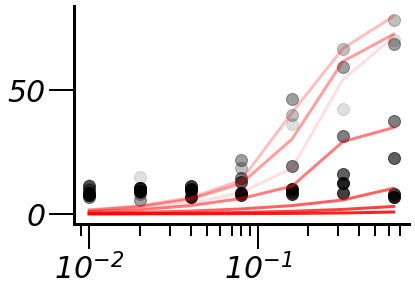

In [1645]:
fixCon = 0;
if fixCon:
    xVals = coreExp['maskSF'];
else:
    xVals = coreExp['maskCon'];
for i in range(7):
    if fixCon:
        plt.semilogx(xVals, mod[i, :, 0], color='r', alpha=(i+1)/8.)
        plt.scatter(xVals, dat[i, :, 0], color='k', alpha=(i+1)/8.)
    else:
        plt.semilogx(xVals, mod[:, i, 0], color='r', alpha=(i+1)/8.)
        plt.scatter(xVals, dat[:, i, 0], color='k', alpha=(i+1)/8.)

In [1646]:
prms = modTrain.named_parameters()
[print(x, '\n') for x in prms];

('prefSf', Parameter containing:
tensor(0.4096, requires_grad=True)) 

('sigLow', Parameter containing:
tensor(0.7047, requires_grad=True)) 

('sigHigh', Parameter containing:
tensor(0.7830, requires_grad=True)) 

('sigma', Parameter containing:
tensor(-1.3577, requires_grad=True)) 

('respExp', Parameter containing:
tensor(0.2992, requires_grad=True)) 

('scale', Parameter containing:
tensor(0.4750, requires_grad=True)) 

('noiseEarly', Parameter containing:
tensor(0.1484, requires_grad=True)) 

('noiseLate', Parameter containing:
tensor(0.1234, requires_grad=True)) 

('gs_mean', Parameter containing:
tensor(0.4552, requires_grad=True)) 

('gs_std', Parameter containing:
tensor(0.2752, requires_grad=True)) 



In [1647]:
### Now, the optimization
# - what to specify...
model = modTrain; # what's our model?

learning_rate = 0.005;
training_parameters = [p for p in model.parameters() if p.requires_grad]
max_epochs = 10;
lossType = 1;
batch_size = 1500;

# --- data wrapping
dw = mrpt.dataWrapper(coreExp, respMeasure=respMeasure)
dataloader = torchdata.DataLoader(dw, batch_size)

# - then set it up
# optimizer = torch.optim.SGD(training_parameters, lr=learning_rate)
optimizer = torch.optim.Adam(training_parameters, amsgrad=True, lr=learning_rate, )
# - then data
# - predefine some arrays for tracking loss
loss_history = []
start_time = time.time()
time_history = []
model_history = []
hessian_history = []

first_pred = model(trInf);
# print(first_pred)

for t in range(max_epochs):
    optimizer.zero_grad()

    loss_history.append([])
    time_history.append([])

    for bb, (feature, target) in enumerate(dataloader):
        predictions = model.forward(feature, respMeasure=respMeasure, returnPsth=0)

        if respMeasure == 1:
            target['resp'][target['maskCon']==0,0] = 1e-6 # force F1 ~= 0 if con of that stim is 0
            target['resp'][target['baseCon']==0,1] = 1e-6 # force F1 ~= 0 if con of that stim is 0
            predictions[target['maskCon']==0,0] = 1e-6 # force F1 ~= 0 if con of that stim is 0
            predictions[target['baseCon']==0,1] = 1e-6 # force F1 ~= 0 if con of that stim is 0
            target['resp'] = target['resp'][:,maskInd];
            target = target['resp'].flatten();
        if respMeasure == 0:
            target = target['resp'].flatten(); # since it's [nTr, 1], just make it [nTr]

        predictions = predictions[:,maskInd];
        predictions = predictions.flatten(); # since it's [nTr, 1], just make it [nTr]
        loss_curr = mrpt.loss_sfNormMod(predictions, target, lossType) #model.lossType)
        
        if np.mod(t,100)==0 and bb==0:
            print('\n****** STEP %d *********' % t)
            prms = model.named_parameters()
            [print(x, '\n') for x in prms];
            print(loss_curr.item())
            print(loss_curr.grad)
        
        loss_history[t].append(loss_curr.item())
        time_history[t].append(time.time() - start_time)
        if np.isnan(loss_curr.item()) or np.isinf(loss_curr.item()):
            # we raise an exception here and then try again.
            raise Exception("Loss is nan or inf on epoch %s, batch %s!" % (t, 0))

        loss_curr.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    model.train()


../model_responses_pytorch.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)



****** STEP 0 *********
('prefSf', Parameter containing:
tensor(0.4096, requires_grad=True)) 

('sigLow', Parameter containing:
tensor(0.7047, requires_grad=True)) 

('sigHigh', Parameter containing:
tensor(0.7830, requires_grad=True)) 

('sigma', Parameter containing:
tensor(-1.3577, requires_grad=True)) 

('respExp', Parameter containing:
tensor(0.2992, requires_grad=True)) 

('scale', Parameter containing:
tensor(0.4750, requires_grad=True)) 

('noiseEarly', Parameter containing:
tensor(0.1484, requires_grad=True)) 

('noiseLate', Parameter containing:
tensor(0.1234, requires_grad=True)) 

('gs_mean', Parameter containing:
tensor(0.4552, requires_grad=True)) 

('gs_std', Parameter containing:
tensor(0.2752, requires_grad=True)) 

4.529471397399902
None


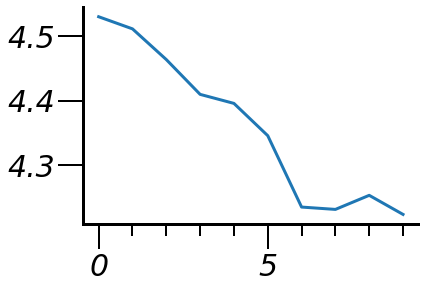

In [1648]:
plt.plot(loss_history);

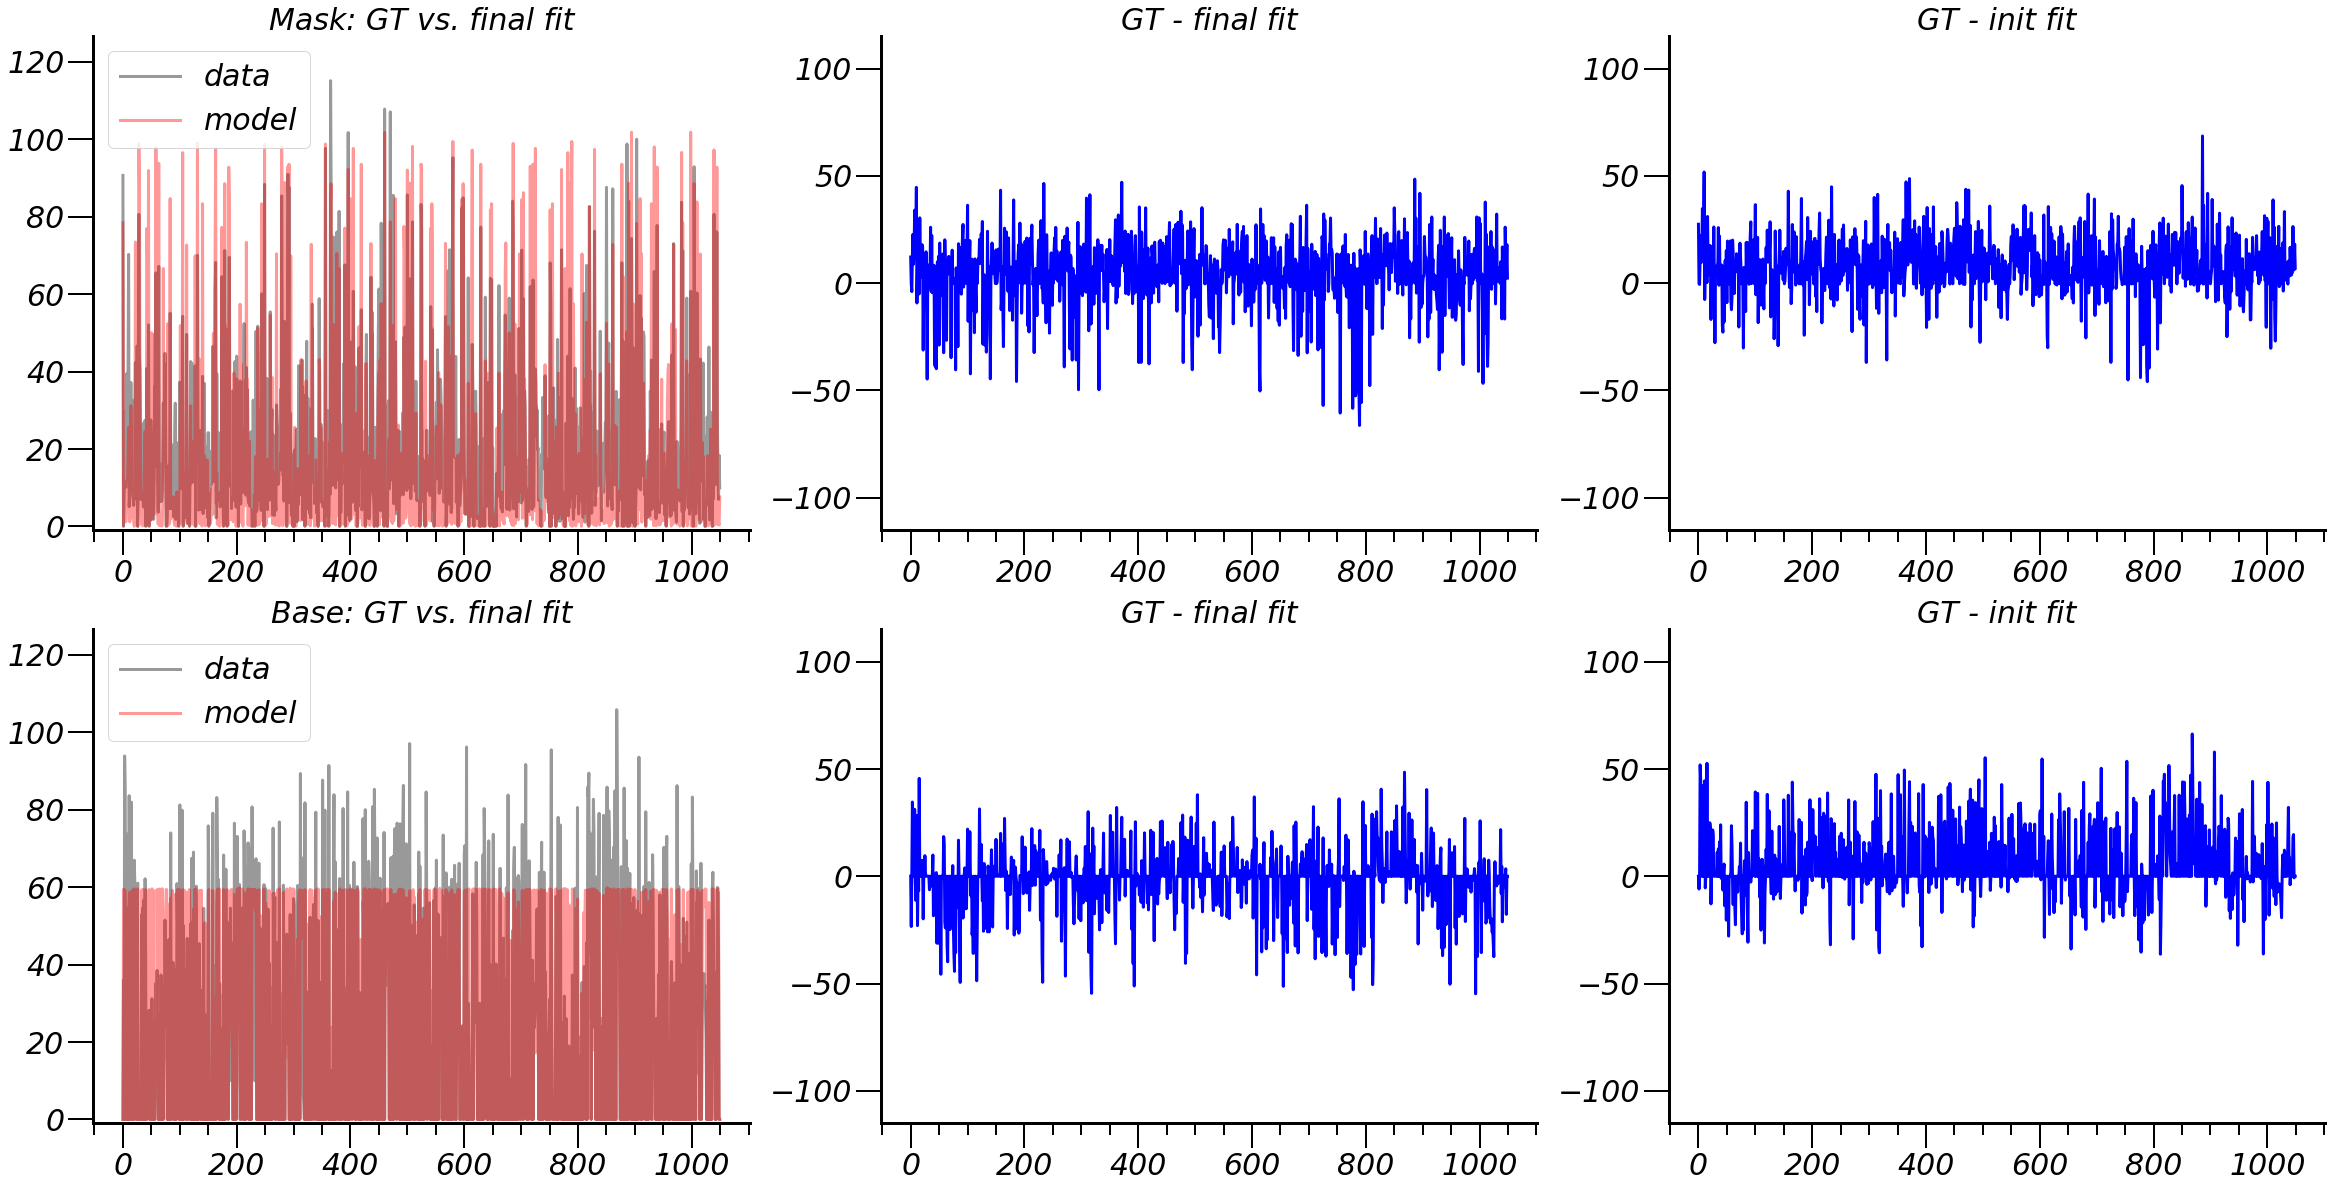

In [1649]:
final_fit = model.forward(trInf, respMeasure=respMeasure, returnPsth=0)
final_fit = final_fit.detach().numpy();

f, ax = plt.subplots(figsize=(40, 20))

if respMeasure == 0:
    resp = resp.squeeze()

max_resp = np.maximum(np.max(resp), np.max(final_fit));

if respMeasure == 0:
    plt.subplot(1,3,1)
    plt.plot(resp, 'k', label='data')
    plt.plot(final_fit, 'r', label='model')
    plt.ylim([-1, 1.1*max_resp]);
    plt.title('GT vs. final fit');
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(resp - final_fit, 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - final fit');

    plt.subplot(1,3,3)
    plt.plot(resp - init_as_np, 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - init fit');

elif respMeasure == 1:
    # Top row is mask
    plt.subplot(2,3,1)
    plt.plot(respFixed[:,0], 'k', label='data', alpha=0.4)
    plt.plot(final_fit[:,0], 'r', label='model', alpha=0.4)
    plt.ylim([-1, 1.1*max_resp]);
    plt.title('Mask: GT vs. final fit');
    plt.legend()

    plt.subplot(2,3,2)
    plt.plot(respFixed[:,0] - final_fit[:,0], 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - final fit');

    plt.subplot(2,3,3)
    plt.plot(respFixed[:,0] - init_as_np[:,0], 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - init fit');

    # Bottom row is base
    plt.subplot(2,3,4)
    plt.plot(respFixed[:,1], 'k', label='data', alpha=0.4)
    plt.plot(final_fit[:,1], 'r', label='model', alpha=0.4)
    plt.ylim([-1, 1.1*max_resp]);
    plt.title('Base: GT vs. final fit');
    plt.legend()

    plt.subplot(2,3,5)
    plt.plot(respFixed[:,1] - final_fit[:,1], 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - final fit');

    plt.subplot(2,3,6)
    plt.plot(respFixed[:,1] - init_as_np[:,1], 'b')
    plt.ylim([-max_resp, max_resp]);
    plt.title('GT - init fit');

In [1650]:
# get out the parameters...
# training_parameters = [p for p in model.parameters() if p.requires_grad]
prms = model.named_parameters()
[print(x, '\n') for x in prms];

('prefSf', Parameter containing:
tensor(0.4361, requires_grad=True)) 

('sigLow', Parameter containing:
tensor(0.7531, requires_grad=True)) 

('sigHigh', Parameter containing:
tensor(0.8304, requires_grad=True)) 

('sigma', Parameter containing:
tensor(-1.3999, requires_grad=True)) 

('respExp', Parameter containing:
tensor(0.3414, requires_grad=True)) 

('scale', Parameter containing:
tensor(0.5194, requires_grad=True)) 

('noiseEarly', Parameter containing:
tensor(0.1392, requires_grad=True)) 

('noiseLate', Parameter containing:
tensor(0.1104, requires_grad=True)) 

('gs_mean', Parameter containing:
tensor(0.4062, requires_grad=True)) 

('gs_std', Parameter containing:
tensor(0.2432, requires_grad=True)) 



In [1702]:
import helper_fcns_sfBB as hf_sf
maskInd, baseInd = hf_sf.get_mask_base_inds()

In [1703]:
data_resps = respFixed[:, baseInd]
mod_resps = final_fit[:, baseInd]
ooh = hf.var_explained(data_resps, mod_resps, None)

In [1704]:
ar.reload(hf_sf)
ar.reload(hf)

<module 'helper_fcns' from '../helper_fcns.py'>

In [1716]:
def organize_valid_conditions(expInfo, resps=None, respMeasure=0, vecCorrected=1, val_trials=None):
    ''' NOTE: Only checked for sfBB_core;
              -- If vecCorrected, the F1 responses will be those in expInfo AUTOMATICALLY (why? we need a spike train, not counts...)
        Must manually enter resps, which we'll pass in as DC; this will give ALL of the mean responses (vector mean, if F1)
        for all valid conditions. Specifically,
        - if DC, [baseOnly, maskOnly, mask+base], which is [[1], [7x7], [7x7]]
        - if F1, [baseOnly, maskOnly, mask+base], which is [[1 {baseTf}], [7x7 {maskOnly}], [7x7 {both_maskTf}], [7x7 {both_baseTf}]]
        Each of the above will be duplicated for the s.e.m., so return mean, s.e.m.
    '''
    maskInd, baseInd = hf_sf.get_mask_base_inds();

    if respMeasure == 0:
        if resps is None:
            resps = expInfo['spikeCounts'];
        _, baseSummary, _ = hf_sf.get_baseOnly_resp(expInfo, dc_resp=resps, val_trials=val_trials);
        # base only
        baseMean, baseSem = baseSummary[respMeasure][0]
        # now get the mask+base response
        bothDC, _ = hf_sf.get_mask_resp(expInfo, withBase=1, dc_resp=resps, val_trials=val_trials); # i.e. get the base response for F1
        bothMean, bothSem = bothDC[:,:,0], bothDC[:,:,1]
        # then, the mask only response
        maskDC, _ = hf_sf.get_mask_resp(expInfo, withBase=0, dc_resp=resps, val_trials=val_trials); # i.e. get the base response for F1
        maskMean, maskSem = maskDC[:,:,0], maskDC[:,:,1]
        
        return [np.array([baseMean]), bothMean, maskMean], [np.array([baseSem]), bothSem, maskSem];
    
    if respMeasure == 1:
        if resps is None:
            resps = np.vstack((expInfo['f1_mask'], expInfo['f1_base'])).transpose();
            
        _, baseSummary, _ = hf_sf.get_baseOnly_resp(expInfo, f1_base=resps[:, baseInd], val_trials=val_trials, vecCorrectedF1=vecCorrected);
        # base only
        if vecCorrected:
            baseMean, baseSem = baseSummary[respMeasure][0][0,0], baseSummary[respMeasure][0][1,0]; # [rM][0][0,:] is r,phi mean; # [rM][0][,0] is r mean, [1][0][1,0] is phi mean
        else:
            baseMean, baseSem = baseSummary[respMeasure][0][0], baseSummary[respMeasure][0][1]; # [rM][0][0,:] is r,phi mean; # [rM][0][,0] is r mean, [1][0][1,0] is phi mean            
        # now get the mask+base response (f1 at base TF)
        _, both_baseTf = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=0, f1_base=resps[:, baseInd], vecCorrectedF1=vecCorrected, val_trials=val_trials); # i.e. get the base response for F1
        # and get the mask+base response (but f1 at mask TF)
        _, both_maskTf = hf_sf.get_mask_resp(expInfo, withBase=1, maskF1=1, f1_mask=resps[:, maskInd], vecCorrectedF1=vecCorrected, val_trials=val_trials); # i.e. get the maskONLY response
        # finally, get the mask only response (f1 at mask TF)
        _, maskOnly = hf_sf.get_mask_resp(expInfo, withBase=0, maskF1=1, f1_mask=resps[:, maskInd], vecCorrectedF1=vecCorrected, val_trials=val_trials); # i.e. get the maskONLY response                     
        # -- if vecCorrected, let's just take the "r" elements, not the phi information                                                                                                      
        if vecCorrected:
            both_baseTf = both_baseTf[:,:,0,:]; # just take the "r" information (throw away the phi)                                                                                       
            maskOnly = maskOnly[:,:,0,:]; # just take the "r" information (throw away the phi)                                                                     
            both_maskTf = both_maskTf[:,:,0,:]; # just take the "r" information (throw away the phi)                                                                         
        both_baseTf_mn, both_baseTf_sem = both_baseTf[:,:,0], both_baseTf[:,:,1]; # just take the "r" information (throw away the phi)                                                                                       
        maskOnly_mn, maskOnly_sem = maskOnly[:,:,0], maskOnly[:,:,1]; # just take the "r" information (throw away the phi)                                                                     
        both_maskTf_mn, both_maskTf_sem = both_maskTf[:,:,0], both_maskTf[:,:,1]; # just take the "r" information (throw away the phi)                                                                         
            
        return [np.array([baseMean]), both_baseTf_mn, both_maskTf_mn, maskOnly_mn], [np.array([baseSem]), both_baseTf_sem, both_maskTf_sem, maskOnly_sem]
    
    

In [1717]:
val_trials = trInf['num'];
respMeas = 1;

# DATA - do vec corrected
mns_dat, sems_dat = organize_valid_conditions(coreExp, resps=None, respMeasure=respMeas, vecCorrected=1)
mns_dat_flat = np.hstack([x.flatten() for x in mns_dat])
# MODEL - NOT vec corrected
mns_mod, sems_mod = organize_valid_conditions(coreExp, resps=final_fit, respMeasure=respMeas, vecCorrected=0, val_trials=val_trials)
mns_mod_flat = np.hstack([x.flatten() for x in mns_mod])

if respMeas == 1:
    mns_dat_base = np.hstack([x.flatten() for x in [mns_dat[0], mns_dat[1]]])
    mns_dat_mask = np.hstack([x.flatten() for x in [mns_dat[2], mns_dat[3]]])
    mns_mod_base = np.hstack([x.flatten() for x in [mns_mod[0], mns_mod[1]]])
    mns_mod_mask = np.hstack([x.flatten() for x in [mns_mod[2], mns_mod[3]]])


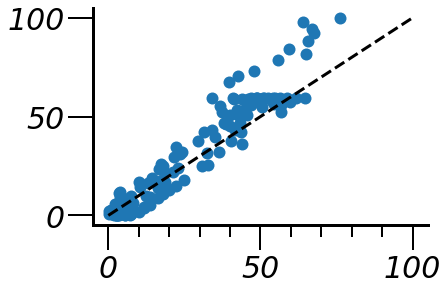

In [1719]:
plt.plot(mns_dat_flat, mns_mod_flat, 'o');
plt.plot([0,100], [0,100], 'k--');

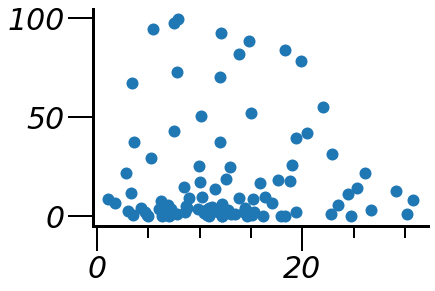

In [1674]:
plt.plot(mns_dat_mask, mns_mod_mask, 'o')

Text(0, 0.5, 'Data')

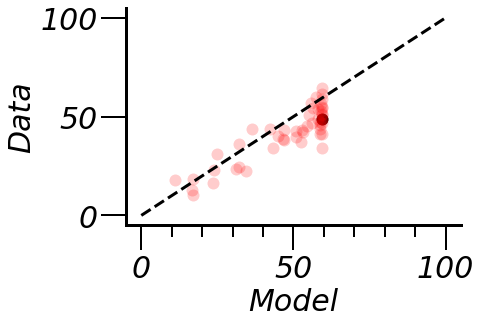

In [1720]:
max_mod = np.max([np.max(x) for x in mns_mod]);
max_dat = np.max([np.max(x) for x in mns_dat]); 
max_plt = 10 * np.ceil(np.maximum(max_mod, max_dat)/10);

[plt.plot(m, d, '%so' % clr, alpha=alph) for m,d,clr,alph in zip(mns_mod, mns_dat,clrs,alphs)];
plt.plot([0, max_plt], [0, max_plt], 'k--');
plt.xlabel('Model');
plt.ylabel('Data')
# plt.legend();

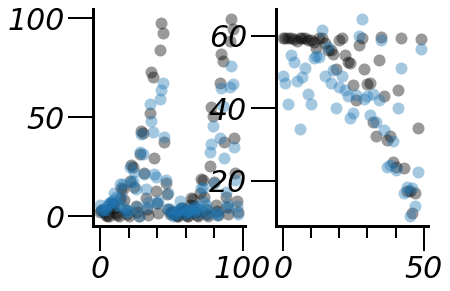

In [1721]:
plt.subplot(1,2,1)
plt.plot(mns_mod_mask, 'ko', alpha=0.4)
plt.plot(mns_dat_mask, 'o', alpha=0.4)

plt.subplot(1,2,2)
plt.plot(mns_mod_base, 'ko', alpha=0.4)
plt.plot(mns_dat_base, 'o', alpha=0.4)

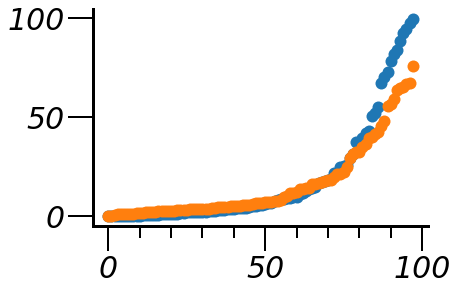

In [1722]:
plt.plot(sorted(mns_mod_mask), 'o')
plt.plot(sorted(mns_dat_mask), 'o')

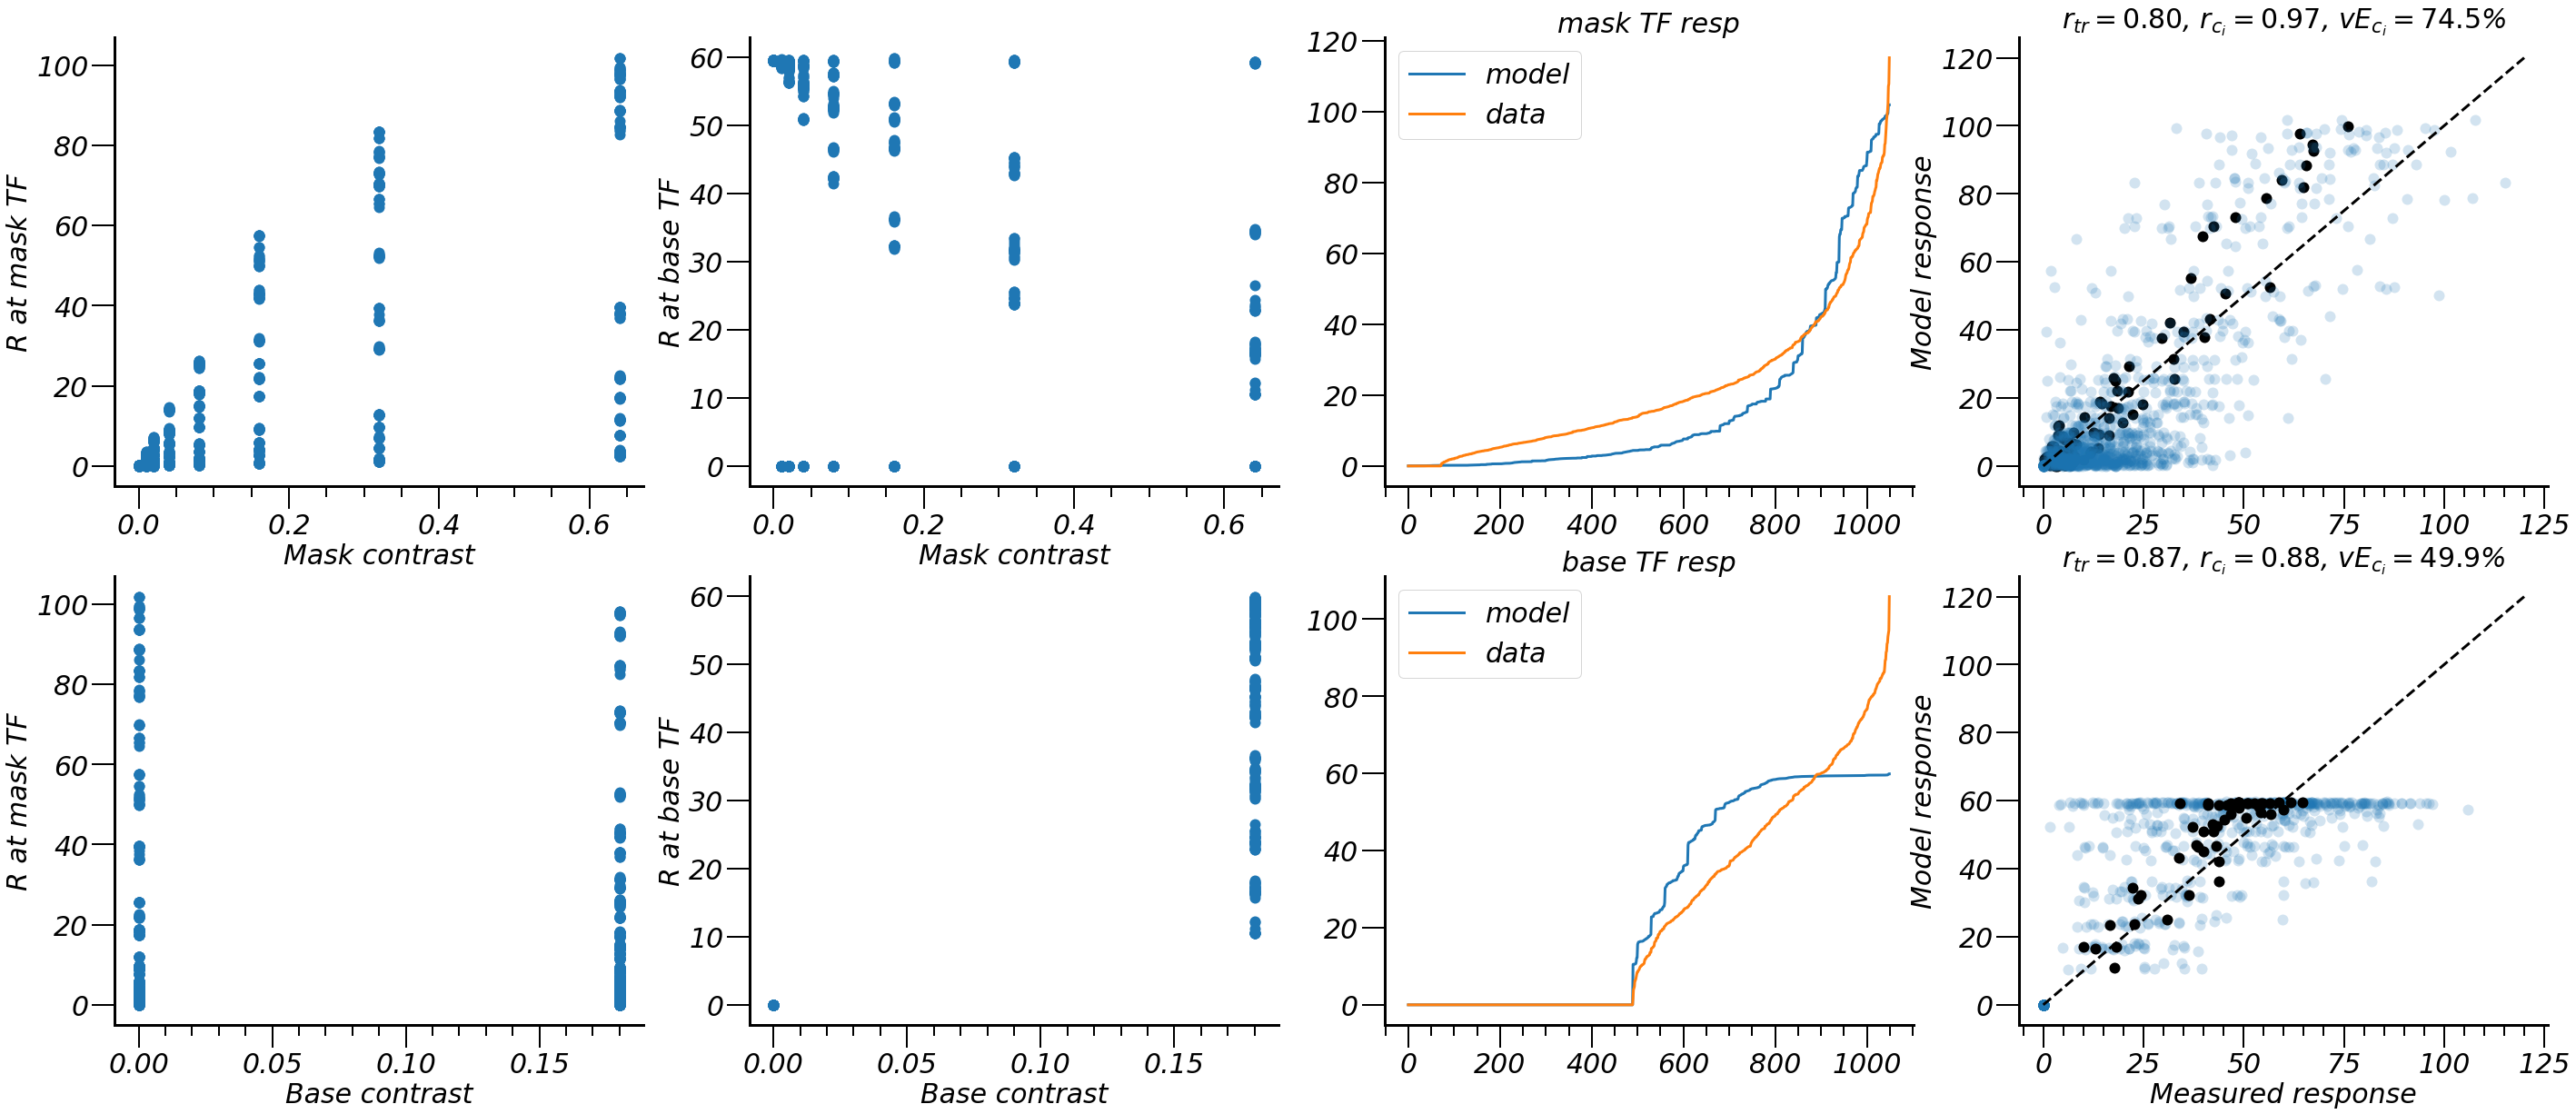

In [1760]:
nRow = 2; nCol = 4;
f, ax = plt.subplots(nRow,nCol,figsize=(12*nCol,10*nRow));

# for plotting condition-averaged mean responses...
clrs = ['k', 'r']
alphs = [1, 0.2]
lbls = ['base', 'maskTf', 'baseTf', 'maskOnly']

max_resp = np.maximum(np.max(respFixed), np.max(final_fit))
max_plt = 10*np.ceil(max_resp/10);

# mask by mask
ax[0,0].plot(trInf['con'][:, maskInd], final_fit[:, maskInd], 'o')
ax[0,0].set_xlabel('Mask contrast');
ax[0,0].set_ylabel('R at mask TF');
# mask by base
ax[0,1].plot(trInf['con'][:, maskInd], final_fit[:, baseInd], 'o')
ax[0,1].set_xlabel('Mask contrast');
ax[0,1].set_ylabel('R at base TF');
# data vs model (just mask F1)
ax[0,2].set_title('mask TF resp')
ax[0,2].plot(sorted(final_fit[:,maskInd]), label='model')
ax[0,2].plot(sorted(respFixed[:,maskInd]), label='data')
ax[0,2].legend();
# data vs model (correlation)
curr_corr_tr = np.corrcoef(respFixed[:,maskInd], final_fit[:,maskInd])
curr_corr_cond = np.corrcoef(mns_dat_mask, mns_mod_mask);
curr_vE_cond = hf.var_explained(mns_dat_mask, mns_mod_mask, None);
ax[0,3].set_title(r'$r_{tr} = %.2f$, $r_{c_i} = %.2f$, $vE_{c_i} = %.1f$%%' % (curr_corr_tr[0,1], curr_corr_cond[0,1], curr_vE_cond))
ax[0,3].plot(mns_dat_mask, mns_mod_mask, 'ko', alpha=1);
# [ax[0,3].plot(m, d, '%so' % clr, alpha=alph) for m,d,clr,alph in zip(mns_mod_mask, mns_dat_mask, clrs,alphs)];
ax[0,3].plot(respFixed[:,maskInd], final_fit[:,maskInd], 'o', alpha=0.2)
ax[0,3].set_ylabel('Model response')
ax[0,3].plot([0, max_plt], [0, max_plt], 'k--')
# ax[0,3].set_xlabel('Measured response')
# ax[0,3].legend();

# base by mask
ax[1,0].plot(trInf['con'][:, baseInd], final_fit[:, maskInd], 'o')
ax[1,0].set_xlabel('Base contrast');
ax[1,0].set_ylabel('R at mask TF');
# base by base
ax[1,1].plot(trInf['con'][:, baseInd], final_fit[:, baseInd], 'o')
ax[1,1].set_xlabel('Base contrast');
ax[1,1].set_ylabel('R at base TF');
# data vs model (just base F1)
ax[1,2].set_title('base TF resp')
ax[1,2].plot(sorted(final_fit[:,baseInd]), label='model')
ax[1,2].plot(sorted(respFixed[:,baseInd]), label='data')
ax[1,2].legend();
# data vs. model (correlation)
curr_corr_tr = np.corrcoef(respFixed[:,baseInd], final_fit[:,baseInd])
curr_corr_cond = np.corrcoef(mns_dat_base, mns_mod_base);
curr_vE_cond = hf.var_explained(mns_dat_base, mns_mod_base, None);
ax[1,3].set_title(r'$r_{tr} = %.2f$, $r_{c_i} = %.2f$, $vE_{c_i} = %.1f$%%' % (curr_corr_tr[0,1], curr_corr_cond[0,1], curr_vE_cond))
ax[1,3].plot(respFixed[:,baseInd], final_fit[:,baseInd], 'o', alpha=0.2)
# [ax[1,3].plot(m, d, '%so' % clr, alpha=alph) for m,d,clr,alph in zip(mns_mod_base, mns_dat_base, clrs,alphs)];
ax[1,3].plot(mns_dat_base, mns_mod_base, 'ko', alpha=1);
ax[1,3].set_ylabel('Model response')
ax[1,3].set_xlabel('Measured response')
ax[1,3].plot([0, max_plt], [0, max_plt], 'k--')
# ax[1,3].legend();


In [1761]:
ar.reload(mrpt);
ar.reload(hfsf);
ar.reload(hf);

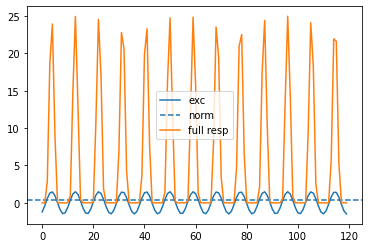

In [787]:
############
# DEBUGGING - use the debug flag in model.forward, be sure to save lexc, linh, sigmaFilt = modTrain.forward(...)
############
modTrain = mrpt.sfNormMod(fp, expInd, excType=excType, normType=normType, lossType=lossType, lgnFrontEnd=lgnFrontEnd, newMethod=newMethod)
model = modTrain; # what's our model?

lexc, linh, sigmaFilt = model.forward(trInf, respMeasure=respMeasure, debug=1)

lexc_np = lexc.detach().numpy()
linh_np = linh.detach().numpy()

# plt.plot(lexc_np[])
early_noise = modTrain.noiseEarly.detach().numpy()
sigma_filt = sigmaFilt.detach().numpy()
respExp = modTrain.respExp.detach().numpy()

numer = early_noise + lexc_np
denom = np.sqrt(sigma_filt + np.square(linh_np))
full = np.transpose(np.power(np.maximum(np.divide(numer, denom), 1e-10), respExp))

spect, amps, _ = mrpt.spike_fft(mrpt._cast_as_tensor([full]), tfs=[[12,13]], stimDur=1)
spect = spect[0].detach().numpy();
amps = amps[0].detach().numpy();

# # then with no norm...
noNorm = np.transpose(np.power(np.maximum(numer, 1e-10), respExp));
spectNN, ampsNN, _ = mrpt.spike_fft(mrpt._cast_as_tensor([noNorm]), tfs=[[12,13]], stimDur=1)
spectNN = spectNN[0].detach().numpy();
ampsNN = ampsNN[0].detach().numpy();

######## plotting

trNum = 1
plt.plot(numer[:,trNum], label='exc')
plt.axhline(denom[trNum], linestyle='--', label='norm')
plt.plot(full[trNum,:], label='full resp')
plt.legend();

# ----------- separate plot

# plt.subplot(1,2,1)
# plt.plot(amps)
# plt.subplot(1,2,2)
# plt.plot(ampsNN)

# ----------- separate plot

# plt.semilogy(amps)
# plt.ylim([1e0, 1e2])
# ----------- separate plot

# plt.semilogy(amps)
# plt.ylim([1e0, 1e2])

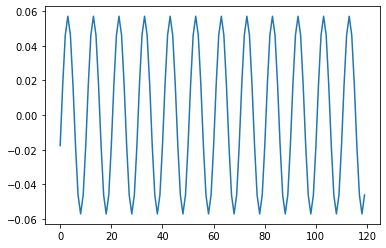

In [73]:
plt.plot(lexc[:,10].detach().numpy())

In [68]:
lexc.shape

torch.Size([120, 1050])

### original/dumb

In [ ]:
# testing flexible_Gauss
# prefSf = 1;
# sigLow = 0.9;
# sigHigh = 0.4;
# testMod = sfNormMod(modParams=[prefSf, sigLow, sigHigh])
# trainMod = sfNormMod(modParams=[prefSf*3, sigLow, sigLow])

# testing DiffOfGauss
# prefSf, gain, gainS, sfS = 3, 1, 0.3, 0.3;
# testMod = sfNormMod(modParams=[prefSf, gain, gainS, sfS])
# trainMod = sfNormMod(modParams=[prefSf, gain, gainS, sfS])

# gain_c, gain_s, r_c, r_s = 100, 10, 0.5, 0.9;
# testMod = sfNormMod(modParams=[gain_c, gain_s, r_c, r_s])
# trainMod = sfNormMod(modParams=[gain_c, gain_s, 2*r_c, r_s])


In [ ]:
### Simple example -- can we recover the original parameters with some added noise...
sfs_data = np.geomspace(0.3, 10.0, 11);
gt_resp = testMod.forward(_cast_as_tensor(sfs_data)).detach().numpy();
# gt_detach = [x.detach().numpy() for x in gt_resp];
sfs_resp = np.clip(np.array([np.random.normal(x, scale=0.01*x) for x in gt_resp]), a_min=1e-4, a_max=None)

init_resp = trainMod.forward(_cast_as_tensor(sfs_data)).detach().numpy();

plt.semilogx(sfs_data, init_resp, 'k', label='init_guess');
plt.semilogx(sfs_data, gt_resp, 'r');
plt.semilogx(sfs_data, sfs_resp, 'ro')
plt.title('data to fit');
plt.legend();

In [ ]:
training_parameters = [p for p in model.parameters() if p.requires_grad]
batch_size = 2;
dataset = _cast_as_tensor(sfs_resp);
max_epochs = 4;
full_data = np.zeros((len(sfs_data), 2));
full_data[:,0] = sfs_data;
full_data[:,1] = sfs_resp;

In [ ]:
### Now, the optimization
# - what to specify...
model = trainMod; # what's our model?

learning_rate = 0.001;
training_parameters = [p for p in model.parameters() if p.requires_grad]
batch_size = 3;
dataset = _cast_as_tensor(sfs_resp);
max_epochs = 1000;
full_data = np.zeros((len(sfs_data), 2));
full_data[:,0] = sfs_data;
full_data[:,1] = sfs_resp;

# - then set it up
# optimizer = torch.optim.SGD(training_parameters, lr=learning_rate)
optimizer = torch.optim.Adam(training_parameters, amsgrad=True, lr=learning_rate, )
# - then data
full_data = dataWrapper(sfs_data, sfs_resp)
dataloader = torchdata.DataLoader(full_data, batch_size)
# - predefine some arrays for tracking loss
loss_history = []
start_time = time.time()
time_history = []
model_history = []
hessian_history = []

first_pred = model(_cast_as_tensor(sfs_data));
# print(first_pred)

for t in range(max_epochs):
    optimizer.zero_grad()

    loss_history.append([])
    time_history.append([])

    for i, (features, target) in enumerate(dataloader):
    
#         features, target = _cast_as_tensor(sfs_data), _cast_as_tensor(sfs_resp);
#         features, target = _cast_as_tensor(sfs_data), _cast_as_tensor(sfs_resp);

        predictions = model(features)
        loss_curr = loss_sfNormMod(predictions, target, model.lossType)
        loss_history[t].append(loss_curr.item())
        time_history[t].append(time.time() - start_time)
        if np.isnan(loss_curr.item()) or np.isinf(loss_curr.item()):
            # we raise an exception here and then try again.
            raise Exception("Loss is nan or inf on epoch %s, batch %s!" % (t, i))
        loss_curr.backward()
        optimizer.step()

    model.eval()
    model.train()


In [ ]:
plt.semilogx(sfs_data, first_pred.detach().numpy(), 'k--', label='initial guess')
plt.semilogx(sfs_data, sfs_resp, 'ro', label='target');
sfs_full = np.geomspace(sfs_data[0], sfs_data[-1], 100);
plt.semilogx(sfs_full, model(_cast_as_tensor(sfs_full)).detach().numpy(), 'k', label='final');
plt.legend()

In [ ]:
plt.plot(np.sum(loss_history, axis=1))

In [ ]:
out_parameters = [p for p in model.parameters() if p.requires_grad]


In [ ]:
out_parameters

In [ ]:
og_pms = [prefSf, gain, gainS, sfS]

In [ ]:
og_pms